I think it's most appropriate to build models for each coral group for *all* islands. I'm looking to predict out to grids that have not been sampled for some of the coral groups in some regions; I don't think conditions will vary so dramatically between islands that island-specific models will offer anything beyond what group-sprecific all-island models offer.

For the models, I'm using group-level data from the following islands:

1. SCLER_CORA: Tut
2. MASSIVE: OfuOlo, Tau, Tut
3. PLATE_LIKE: Tut
4. ENCRUSTING: OfuOlo, Tau, Tut
5. BRANCHING: OfuOlo, Tau, Tut
6. COLUMNAR: OfuOlo, Tau, Tut
7. FREE_LIVIN: OfuOlo, Tau, Tut

I need to...
    - [X] load all dfs
    - [X] add island col as ID
    - [X] rbind the dfs by group
    - check for duplicates, outliers, correlations > 0.7 (by 5/22)
    - impute any missing data (by 5/22)
    - run basic GLM (by 5/29)
    - run random forest classifier on binary (by 5/29)
    - run random forest regressor on abundance (by 5/29)
    - choose, check the metrics of all models (by 6/5)
    - load, add island col as ID, rbind all 5 regional dfs (by 6/5)
    - using the best model, predict out for each group (by 6/5)

Notes: 
    - https://rspatial.org/raster/analysis/5-global_regression.html
    - https://www.r-bloggers.com/how-to-implement-random-forests-in-r/
    - http://ugrad.stat.ubc.ca/R/library/randomForest/html/randomForest.html

### Load libraries

In [49]:
library(dismo)
library(lattice)
library(raster)
library(rgdal)
library(sp)

### Reload dataframes, add island column as ID

##### OfuOlo

In [50]:
setwd('C:/Users/linds/OneDrive/Documents/samoa_corals_data/OfuOlo/')

oo_branching<-read.csv('oo_branching_df.csv')
oo_columnar<-read.csv('oo_columnar_df.csv')
oo_encrusting<-read.csv('oo_encrusting_df.csv')
oo_free_livin<-read.csv('oo_free_livin_df.csv')
oo_massive<-read.csv('oo_massive_df.csv')

oo_branching['ID']<-'OfuOlo'
oo_columnar['ID']<-'OfuOlo'
oo_encrusting['ID']<-'OfuOlo'
oo_free_livin['ID']<-'OfuOlo'
oo_massive['ID']<-'OfuOlo'

##### Tau

In [51]:
setwd('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tau/')

tau_branching<-read.csv('tau_branching_df.csv')
tau_columnar<-read.csv('tau_columnar_df.csv')
tau_encrusting<-read.csv('tau_encrusting_df.csv')
tau_free_livin<-read.csv('tau_free_livin_df.csv')
tau_massive<-read.csv('tau_massive_df.csv')

tau_branching['ID']<-'Tau'
tau_columnar['ID']<-'Tau'
tau_encrusting['ID']<-'Tau'
tau_free_livin['ID']<-'Tau'
tau_massive['ID']<-'Tau'

##### Tutuila

In [53]:
setwd('C:/Users/linds/OneDrive/Documents/samoa_corals_data/Tut/')

tut_branching<-read.csv('tut_branching_df.csv')
tut_columnar<-read.csv('tut_columnar_df.csv')
tut_encrusting<-read.csv('tut_encrusting_df.csv')
tut_free_livin<-read.csv('tut_free_livin_df.csv')
tut_massive<-read.csv('tut_massive_df.csv')
plate<-read.csv('tut_plate_df.csv')
scler<-read.csv('tut_scler_df.csv')

tut_branching['ID']<-'Tut'
tut_columnar['ID']<-'Tut'
tut_encrusting['ID']<-'Tut'
tut_free_livin['ID']<-'Tut'
tut_massive['ID']<-'Tut'
plate['ID']<-'Tut'
scler['ID']<-'Tut'

### rbind() dataframes together by coral type

In [54]:
# Branching
branching<-rbind(oo_branching, tau_branching)
branching<-rbind(branching, tut_branching)

# Columnar
columnar<-rbind(oo_columnar, tau_columnar)
columnar<-rbind(columnar, tut_columnar)

# Encrusting
encrusting<-rbind(oo_encrusting, tau_encrusting)
encrusting<-rbind(encrusting, tut_encrusting)

# Free_livin
free_livin<-rbind(oo_free_livin, tau_free_livin)
free_livin<-rbind(free_livin, tut_free_livin)

# Massive
massive<-rbind(oo_massive, tau_massive)
massive<-rbind(massive, tut_massive)

### Check for duplicates, outliers, correlations > 0.7

#### Correlation scatterplot function

In [55]:
panel.cor<-function(x,y,digits=2,prefix="",cex.cor,...) {
usr<-par("usr")
on.exit(par(usr))
par(usr=c(0,1,0,1))
r<-abs(cor(x,y,use="complete.obs"))
txt<-format(c(r,0.123456789),digits=digits)[1]
txt<-paste(prefix,txt,sep="")
if(missing(cex.cor))cex.cor<-1.0/strwidth(txt)
text(0.5,0.5,txt,cex=cex.cor*(1+r)/2)
}
panel.hist<-function(x,...) {
usr<-par("usr")
on.exit(par(usr))
par(usr=c(usr[1:2],0,1.5))
h<-hist(x,plot=FALSE)
breaks<-h$breaks
nB<-length(breaks)
y<-h$counts
y<-y/max(y)
rect(breaks[-nB],0,breaks[-1],y,col="white",...)
}

##### Branching

In [56]:
coords<-cbind(branching$lon,branching$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

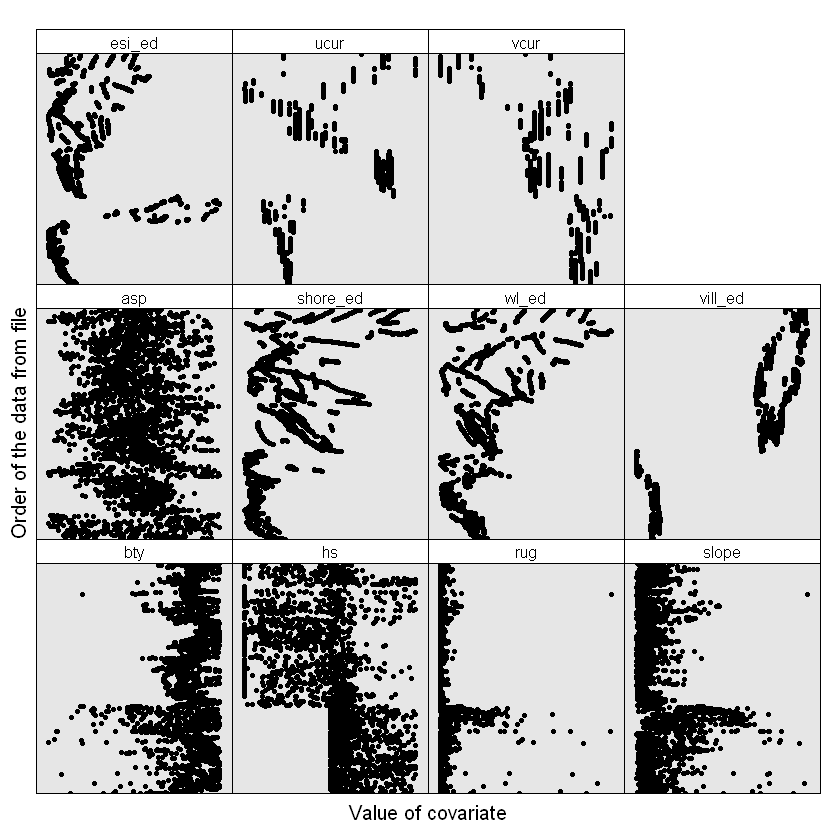

In [57]:
Z<-branching[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

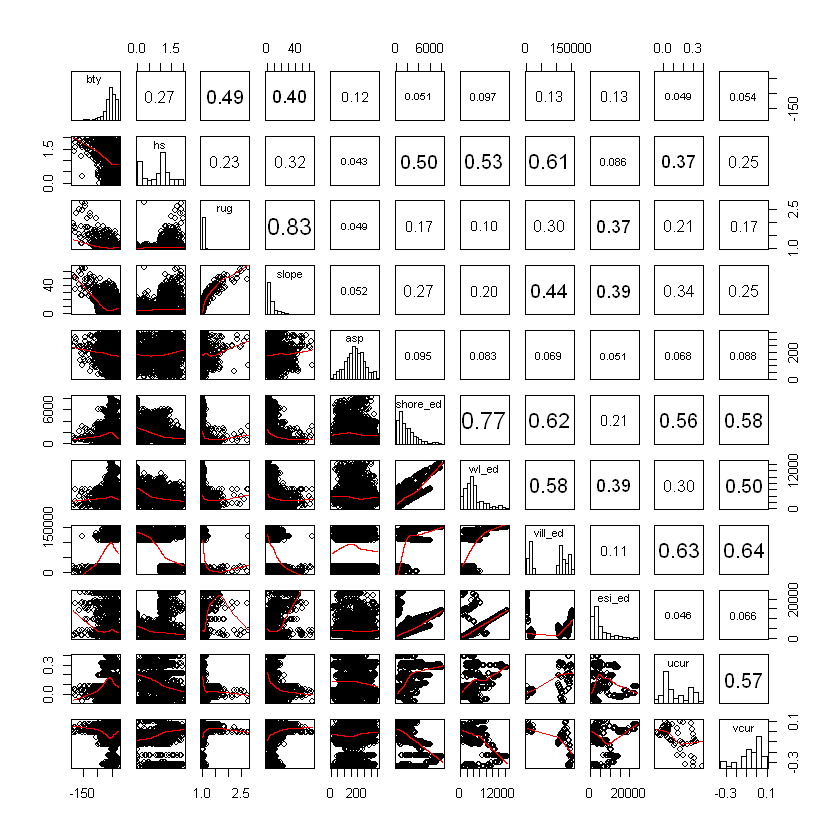

In [58]:
pairs(branching[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Columnar

In [59]:
coords<-cbind(columnar$lon,columnar$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

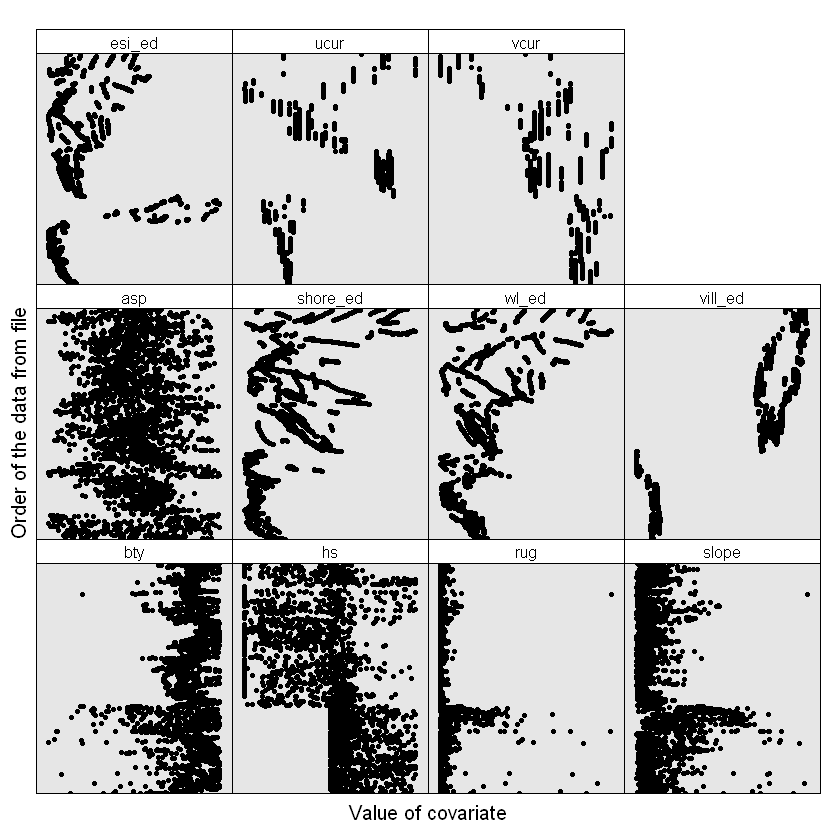

In [60]:
Z<-columnar[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

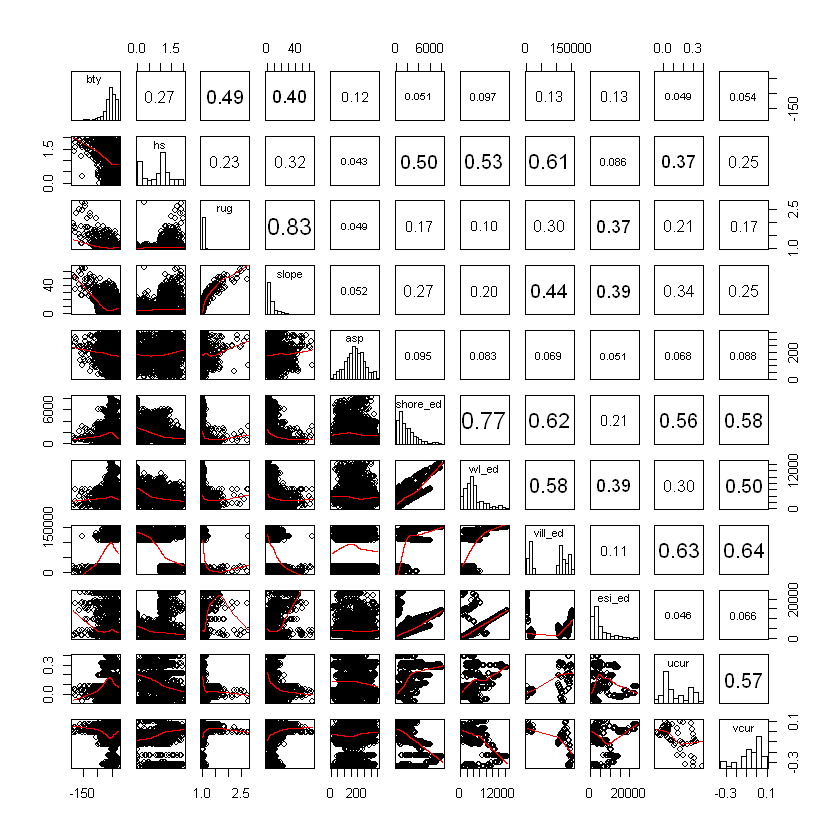

In [61]:
pairs(columnar[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Encrusting

In [62]:
coords<-cbind(encrusting$lon,encrusting$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

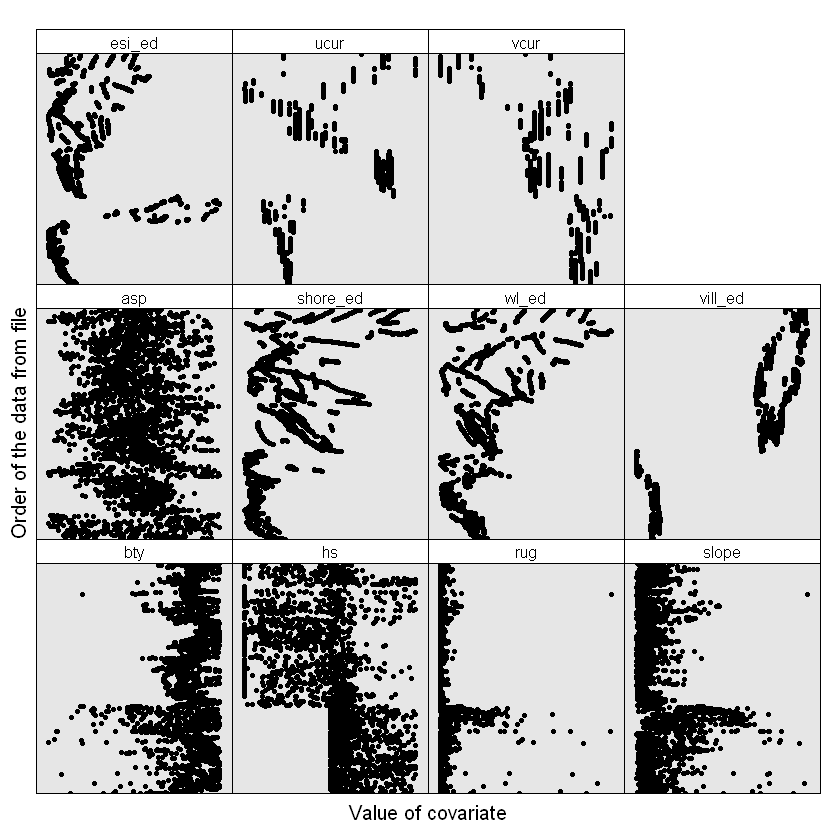

In [63]:
Z<-encrusting[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

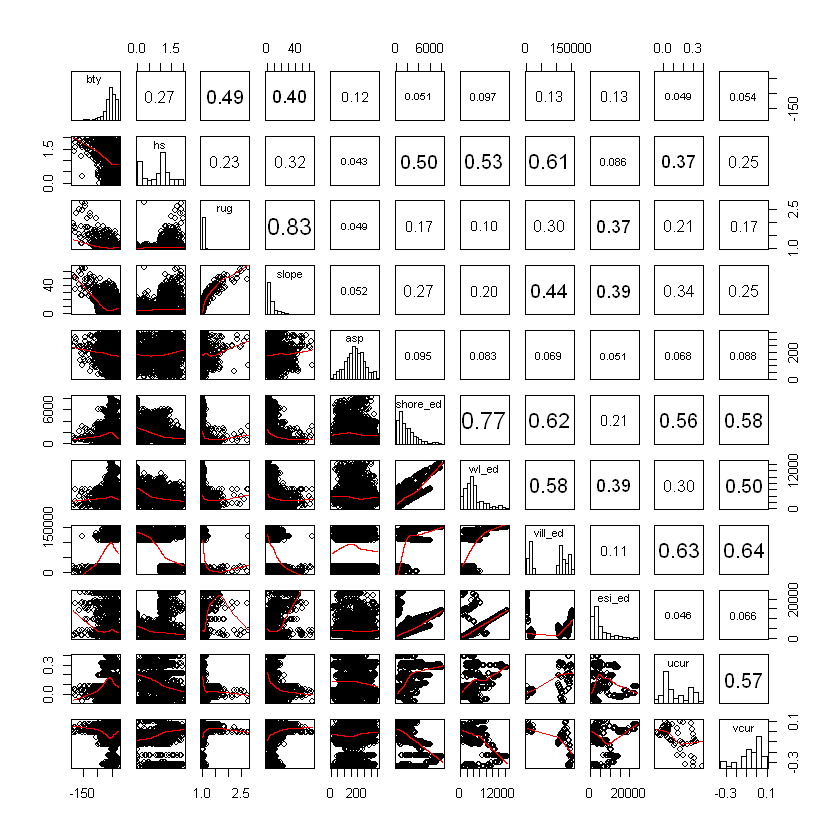

In [64]:
pairs(encrusting[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Free living

In [65]:
coords<-cbind(free_livin$lon,free_livin$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

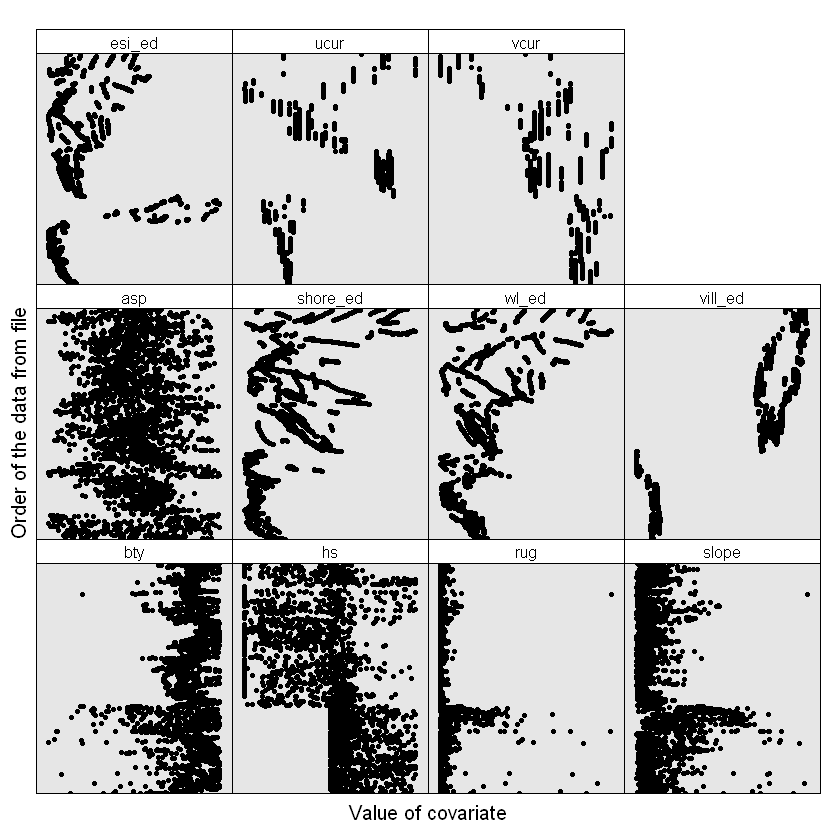

In [66]:
Z<-free_livin[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

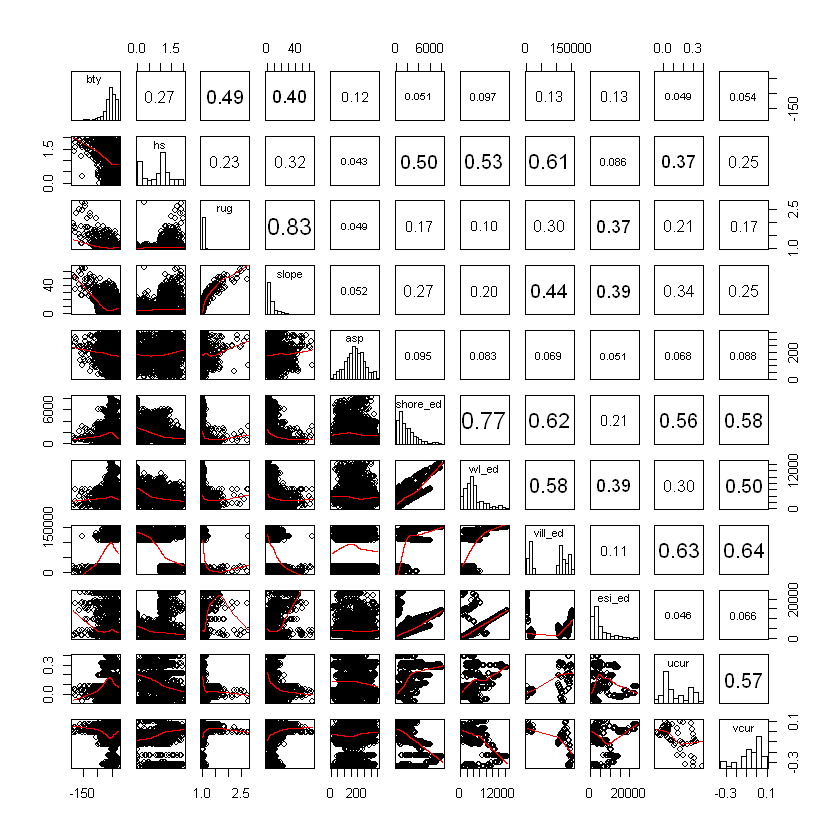

In [67]:
pairs(free_livin[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Massive

In [68]:
coords<-cbind(massive$lon,massive$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

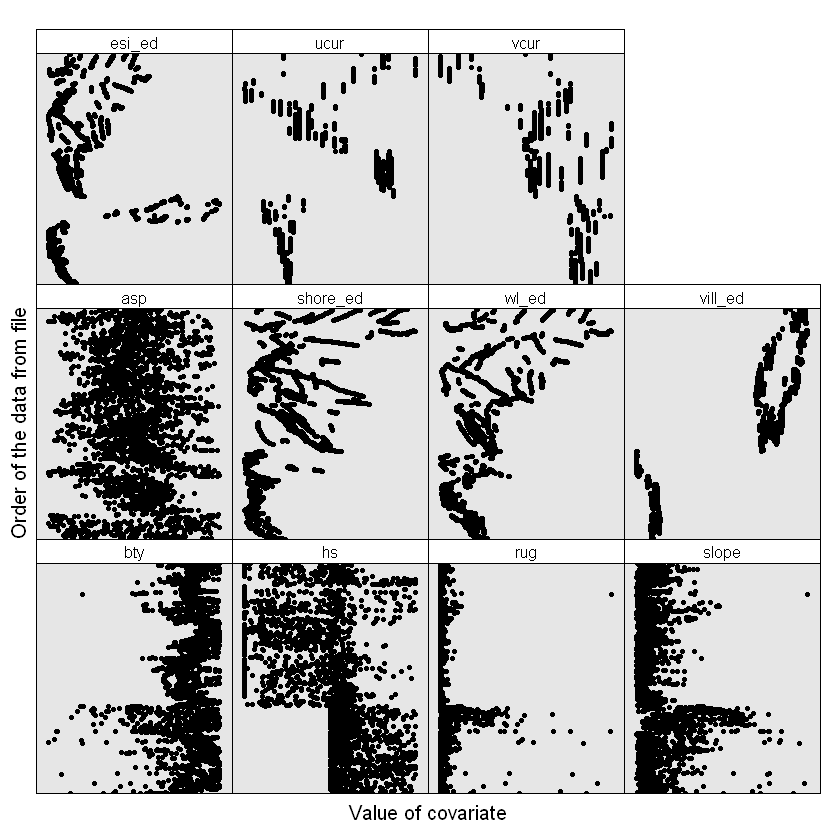

In [69]:
Z<-massive[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

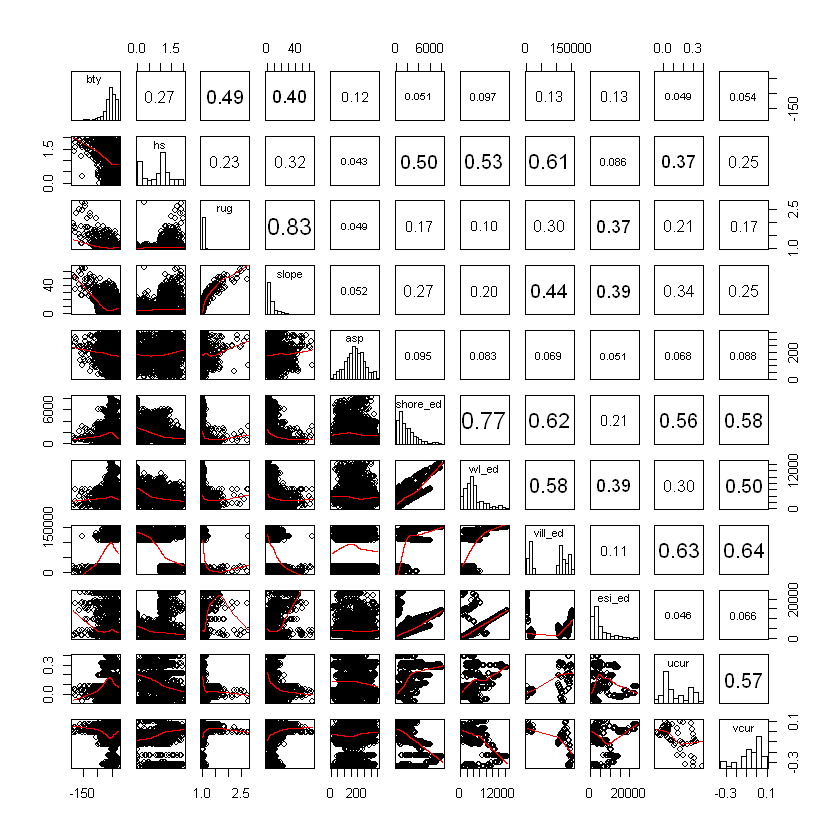

In [70]:
pairs(massive[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Plate

In [71]:
coords<-cbind(plate$lon,plate$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

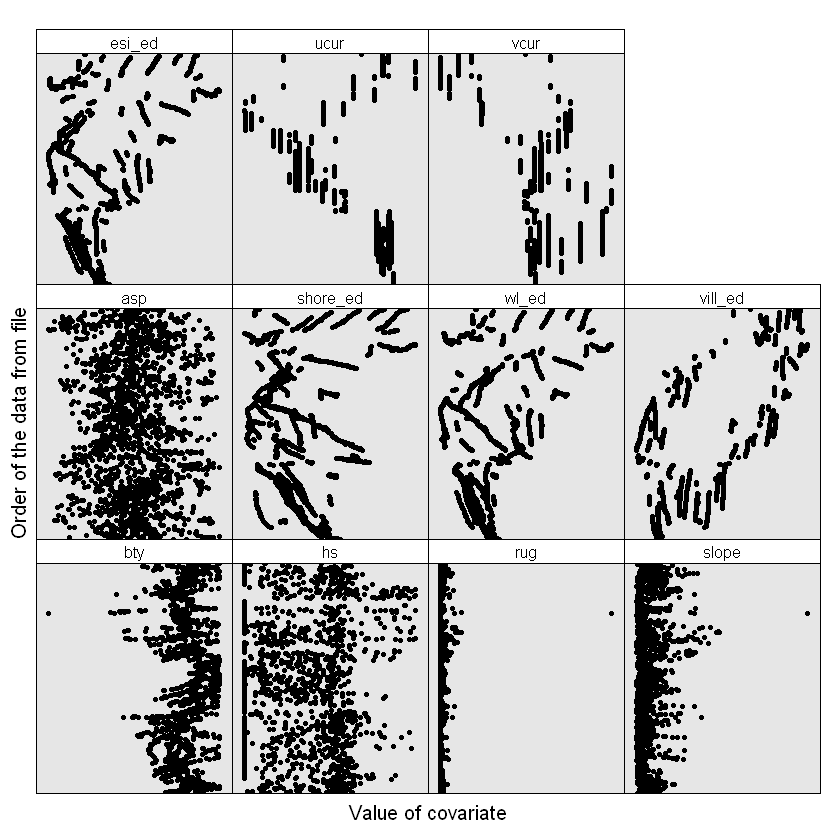

In [72]:
Z<-plate[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

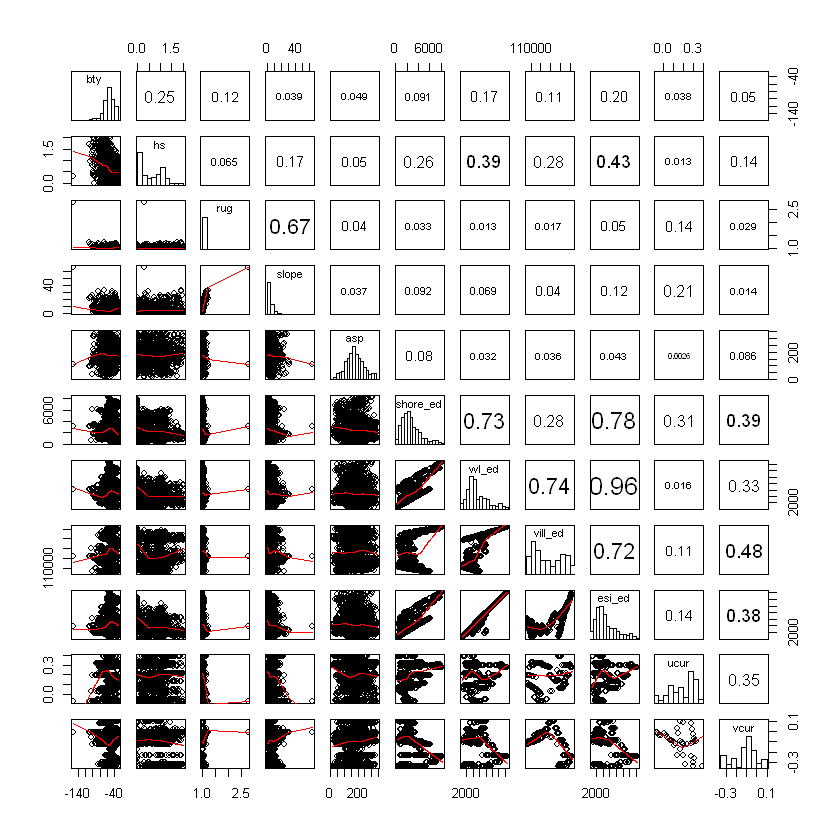

In [73]:
pairs(plate[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

##### Scler

In [74]:
coords<-cbind(scler$lon,scler$lat)
coordsSP<-SpatialPoints(coords,proj4string=CRS(as.character(NA)))
zerodist(coordsSP,zero=0.0)

[,1] [,2]

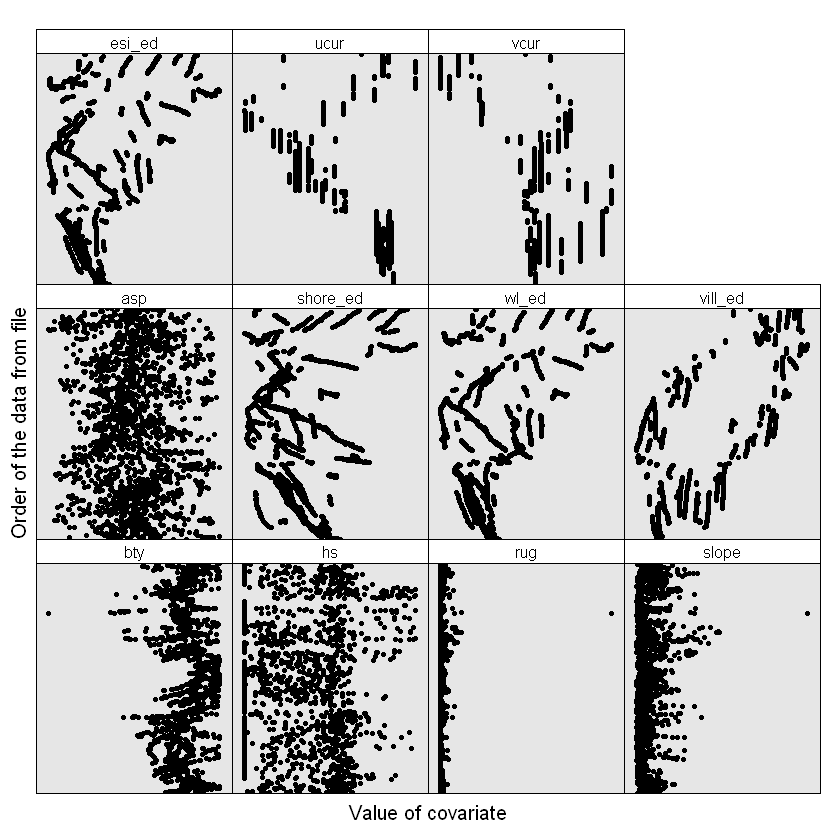

In [75]:
Z<-scler[,c(7:13, 15, 17:19)]
dotplot(as.matrix(Z),groups=FALSE,
        strip=strip.custom(bg='white',par.strip.text=list(cex=0.8)),
        scales=list(x=list(relation="free"),y=list(relation="free"),
        draw=FALSE),col=1,cex=0.5,pch=16,xlab="Value of covariate",
        ylab="Order of the data from file")

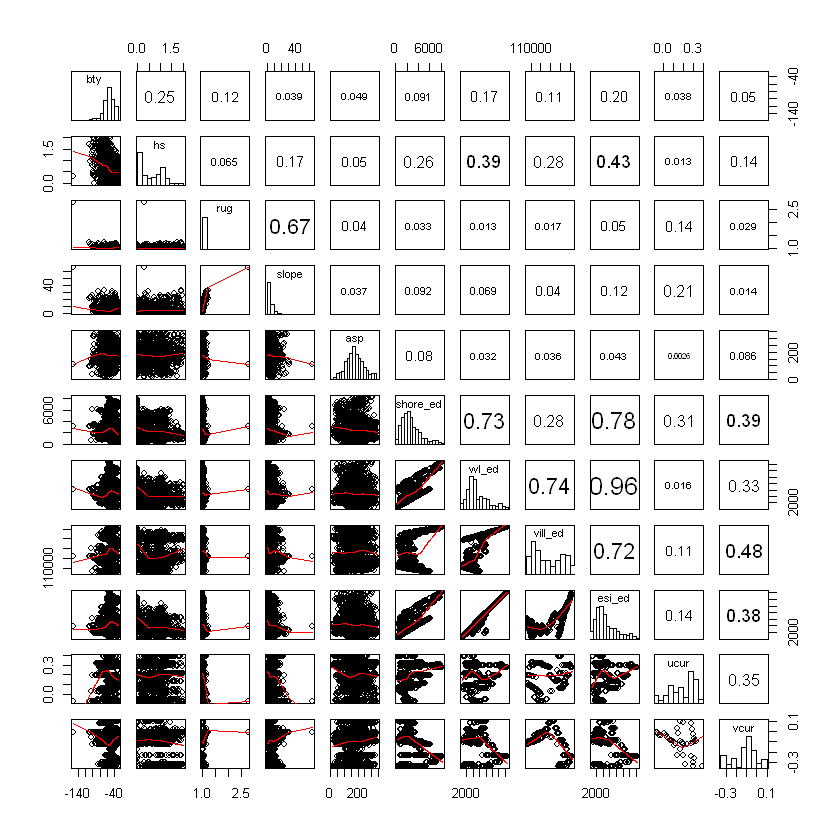

In [76]:
pairs(scler[,c(7:13, 15, 17:19)],upper.panel=panel.cor,diag.panel=panel.hist,lower.panel=panel.smooth)

### Impute missing data